<font color='blue' size=5><b>Комментарий ревьюера</b></font>

<font color='blue'>Привет, Станислав! Меня зовут Павел Григорьев, и я буду проверять этот проект.<br>Моя основная цель - не указать на совершённые тобой ошибки, а поделиться своим опытом и помочь тебе совершенствоваться как профессионалу.<br>Спасибо за проделанную работу! Предлагаю общаться на «ты».</font>
<details>
	<summary><u>Инструкция по организационным моментам (кликабельно)</u>⤵</summary>
<font color='blue'>Я буду использовать различные цвета, чтобы было удобнее воспринимать мои комментарии:</font>


---


<font color='blue'>синий текст - просто текст комментария</font>

<font color='green'>✔️ и зеленый текст - все отлично</font>

<font color='orange'>⚠️ и оранжевый текст - сделано все правильно, однако есть рекомендации, на что стоит обратить внимание</font>

<font color='red'>❌ и красный текст - есть недочеты</font>


</details>    
</br>
<font color='blue'>Пожалуйста, не удаляй мои комментарии в случае возврата работы, так будет проще разобраться, какие были недочеты, а также сразу увидеть исправленное. </font>

<font color='blue'>Ответы на мои комментарии лучше тоже помечать.

Например: </font><br><font color='purple'><b>Комментарий студента</b></font>

<font color='blue'><b>Давай смотреть, что получилось!</b></font>

# Прогнозирование заказов такси

## Описание проекта

### Описание данных

* Имеются исторические данные о заказах такси в аэропортах. 
* Нужно построить модель для прогнозирования количества заказов такси на следующий час. 
* Значение метрики RMSE на тестовой выборке должно быть не больше 48.

### План

* Загрузить данные и выполнить их ресемплирование по одному часу.
* Проанализировать данные.
* Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
* Проверить данные на тестовой выборке и сделайте выводы.

## Инициализация констант и импорты библиотек

In [1]:
from typing import Literal
import pandas as pd
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import root_mean_squared_error
from sklearn.dummy import DummyRegressor

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️ <br>
<font color='green'>Здорово, что все импорты находятся в одной ячейке.<br>
Если хочешь сделать ещё лучше, соблюдай стандарт PEP-8, разбей импорты на функциональные группы, раздели группы пустой строкой. Можно в каждой группе отсортировать импорты в алфавитном порядке.<br>
Ссылка для ознакомления: https://pythonworld.ru/osnovy/pep-8-rukovodstvo-po-napisaniyu-koda-na-python.html
</font>

In [2]:
RANDOM_STATE = 12345

## Загрузка и предобработка данных

### Загрузка и изучение данных

In [3]:
try:
    data = pd.read_csv('../../datasets/taxi.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv')

In [4]:
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')
data.set_index('datetime', inplace=True)

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'>Здорово, что время сразу в индексе!</font>

In [5]:
data.sort_index(inplace=True)

In [6]:
data.index.is_monotonic_increasing

True

In [7]:
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [9]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


### Предобработка данных

In [10]:
data.isna().sum()

num_orders    0
dtype: int64

Дубликаты в таких данных искать нет смысла, это могут быть просто повторяющиеся значения в разное время.

In [11]:
data = data.resample('1H').sum()
data.head()

C:\Users\klpkv\AppData\Local\Temp\ipykernel_21368\1331465909.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data = data.resample('1H').sum()


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> Ресемплирование по часу выполнено верно. Супер, что значения просуммированы, это проще интерпретируется, чем использование других агрегационных функций.</font>

In [12]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


### Выводы по разделу

* Колонку с датой и временем изменил на тип datetime и сделал индексом.
* Отсортировал индексы в хронологическом порядке.
* Пропусков в данных нет.
* Ресемплировал данные по 1 часу.

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'>Данные загружены корректно, первичный осмотр проведен.</font>

## Анализ данных

### Проверка выбросов в данных

<AxesSubplot:ylabel='Frequency'>

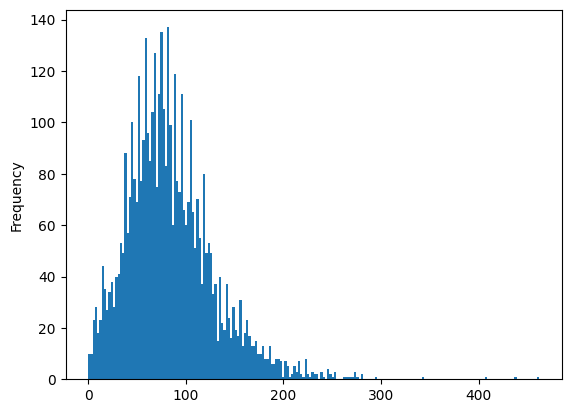

In [13]:
data['num_orders'].plot(kind='hist', bins=200)

В данных видны выбросы (после 280 прочти нет значений)

<AxesSubplot:xlabel='datetime'>

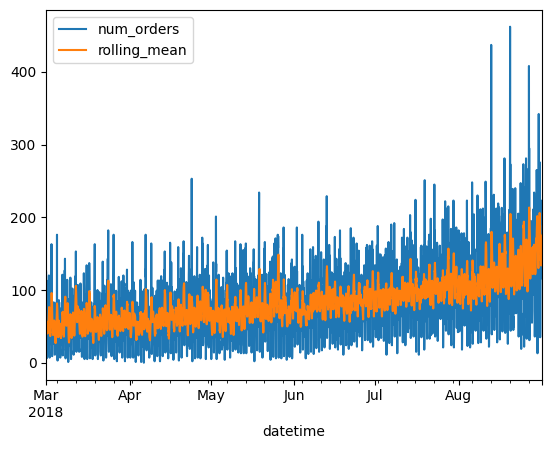

In [14]:
data['rolling_mean'] = data['num_orders'].rolling(10).mean() 
data.plot()

### Тренд и сезонность

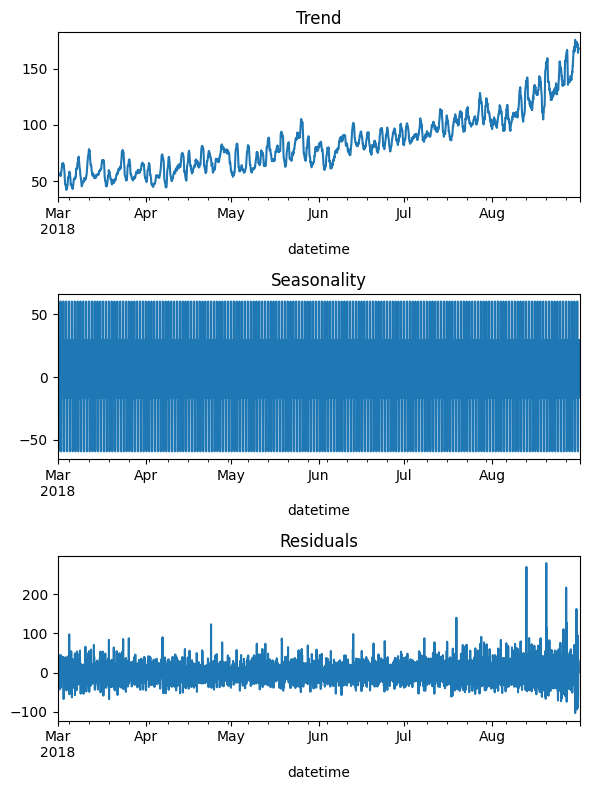

In [15]:
decomposed = seasonal_decompose(data['num_orders'])

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()


Сезонность внутри одного дня.

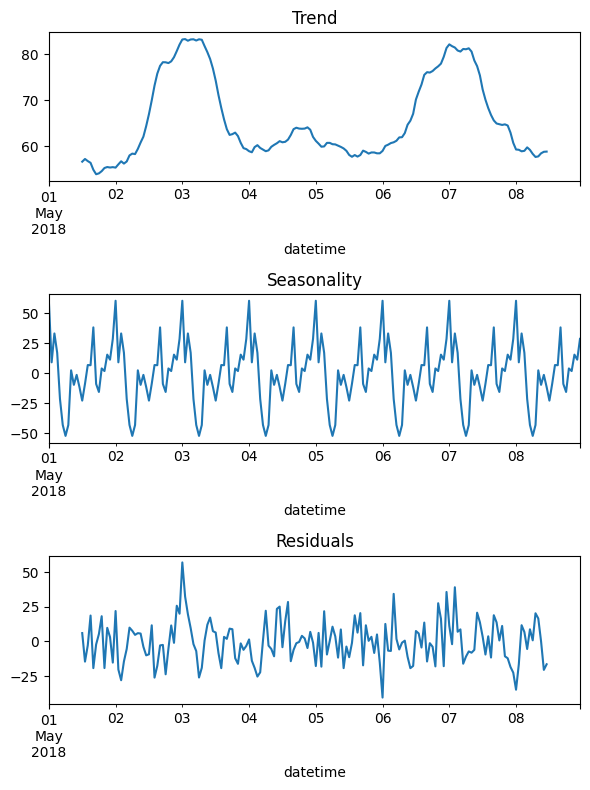

In [16]:
decomposed = seasonal_decompose(data['num_orders']['2018-05-01':'2018-05-08'])

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

* В данных прослеживается восходящий тренд.
* Видимо в данных несколько сезонностей, поэтому стандартным инструментом не получилось их все вытащить.

<font color='purple'><b>Можешь посоветовать инструменты, которые автоматически могут показать все сезонности?.</b></font>

<font color='blue'><b>Комментарий ревьюера: </b></font> ❌\
<font color='red'> Нужно посмотреть сезонности ряда, что бы график был информативен нужно выбрать интервал, что бы был виден каждый час.</font>

<font color='blue'><b>Комментарий ревьюера: </b></font> ⚠️\
<font color='darkorange'> Если ресемлировать ряд по дню и вывести интервал около месяца, то можно увидеть сезонность внутри недели.</font>

Сезонность внутри недели

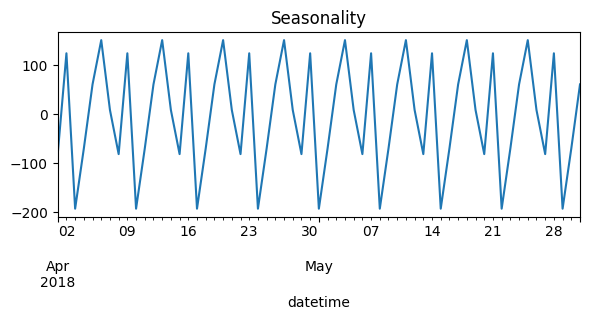

In [17]:
decomposed = data['num_orders'].resample('1D').sum()
decomposed = decomposed['2018-04':'2018-05']

decomposed = seasonal_decompose(decomposed)

plt.figure(figsize=(6, 8))
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.tight_layout()

In [18]:
data['mean'] = data['num_orders'].rolling(15).mean()
data['std'] = data['num_orders'].rolling(15).std()

<AxesSubplot:xlabel='datetime'>

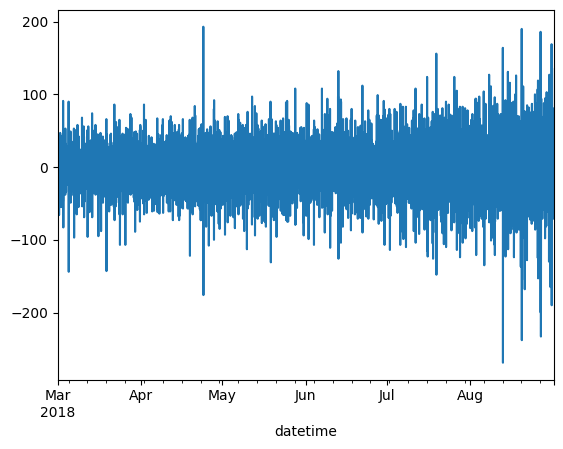

In [19]:
data['diff'] = data['num_orders'] - data['num_orders'].shift()
data['diff'].plot()

In [20]:
adfuller(data['num_orders'])

(-3.0689242890279536,
 0.028940051402613094,
 30,
 4385,
 {'1%': -3.431842162413052,
  '5%': -2.8621993540813637,
  '10%': -2.567120978470452},
 41728.71357827463)

<font color='purple'><b>Не понял как работает тест Дики-Фуллера (на какие значения обращать внимание) и в целом чем полезна стационарность при создании моделей для временных рядов.</b></font>

<font color='blue'><b>Комментарий ревьюера: </b></font> ⚠️\
<font color='darkorange'>Стационарность мы можем проверить, применив тест [Дики-Фуллера](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html)</font>

In [21]:
(
    data[['num_orders']]
    .quantile([0.0012, 0.05, .5, .95, .9988])
    .style.format("{:,.2f}")
)

,num_orders
0.001200,2.00
0.050000,21.00
0.500000,78.00
0.950000,166.00
0.998800,281.00


### Вывод по разделу

* В данных видны выбросы (после 280 прочти нет значений)
* В данных прослеживается восходящий тренд.
* Есть несколько сезонностей: сезонность внутри дня и сезонность внутри недели.

## Обучение моделей

### Погдотовка данных к обучению

In [22]:
train, test = train_test_split(pd.DataFrame(data['num_orders'], index=data.index), shuffle=False, test_size=.1)

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'>Верно, что запрещаешь перемешивание отчётов.</font>

<font color='purple'><b>Убрал проверки датасетов, они были лишние.</b></font>

<font color='blue'><b>Комментарий ревьюера: </b></font> ⚠️\
<font color='darkorange'>Датафреймы лучше всегда ограничивать методами .head(), .tail(), sample(). Иначе в выводах ячейки записывается весь Датафрейм, хоть он и не выводится на экран полностью. Такие Аутпуты сильно перегружают тетрадку.</font>

In [23]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


<font color='blue'><b>Комментарий ревьюера: </b></font> ❌\
<font color='red'>На мой взгляд: не все признаки подходят, чисто логически. Выскажу свою позицию:<br>

<font color='red'>1) Признак год: НЕТ, однозначно не подходит. У нас данных меньше года. Поэтому будет просто константа.<br>
2) Признак месяц: НЕТ, аналогично году, у нас в истории всего один март, май.... Да и горизонт прогноза - часы. Поэтому сезонность времени года будет просто в тренде уже заложена.</font><br>
<font color='darkorange'>3) Признак день: НЕТ, также не подходит, у нас нет сезонности внутри месяца, будет просто последовательность чисел.<br></font>
<font color='green'>4) Признак день недели: ДА, т.к. у нас есть недельная сезонность.<br>
5) Признак час: ДА, т.к. есть часовая (суточная) сезонность.<br>
6) Признак lag: ДА, это параметр авторегрессии - учёт влияния вчерашних событий на сегодняшние.<br>
7) Признак rolling: ДА, это аналог тренда. Чем больше окно сглаживания, тем ровнее линия тренда.</font> <br>

<font color='red'>Как ты думаешь?</font>

<font color='purple'><b>Полностью с этим согласен.</b></font>

In [24]:
make_features(train, 14, 10)
train.dropna(inplace=True)
make_features(test, 14, 10)
test.dropna(inplace=True)

<font color='purple'><b>Здесь взял методом проб и ошибок взял 14. Как ориентируясь на сезонности подбирать временной сдвиг?.</b></font>

<font color='blue'><b>Комментарий ревьюера: </b></font> ⚠️\
<font color='darkorange'> Временной сдвиг лучше определить с учётом выявленных сезонностей\
Или можно подобрать лучшее сочетание предиктеров в цикле.</font>

<font color='blue'><b>Комментарий ревьюера: </b></font> ⚠️\
<font color='darkorange'>Можно, так же, посмотреть Автокорреляцию и оставить только значимые Лаги. Чем меньше признаков - тем модели проще расчитать прогноз. [Автокоррелеляция](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)</font>

In [25]:
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

### Работа с моделями

In [26]:
# Класс для работы с моделями
class MultiModelLearning:
    def __init__(self, model_name: Literal['linear_regressor', 'tree', 'bagging', 'boosting', 'dummy', 'ANN']):
        self.model_name = model_name
        if model_name == 'linear_regressor':
            self.model = LinearRegression()
        elif model_name == 'tree':
            self.model = DecisionTreeRegressor(random_state=RANDOM_STATE)
        elif model_name == 'bagging':
            self.model = BaggingRegressor(random_state=RANDOM_STATE)
        elif model_name == 'boosting':
            self.model = LGBMRegressor(random_state=RANDOM_STATE)
        elif model_name == 'dummy':
            self.model = DummyRegressor(strategy="mean")
        elif model_name == 'ANN':
            self.model = MLPRegressor(random_state=RANDOM_STATE, solver='sgd', activation='logistic', shuffle=False)
        else:
            display("Было введено неверное имя модели")
        self.features = None
        self.target = None
        self.best_model = None
        self.best_score = None
        self.best_params = None

    # Подбор гиперпараметров для модели
    def select_hyperparameters__(self, param_dist):
        tscv = TimeSeriesSplit(n_splits=3)
        grid_search = GridSearchCV(self.model, param_grid=param_dist, cv=tscv, scoring='neg_root_mean_squared_error')
        grid_search.fit(self.features, self.target)
        self.best_model = grid_search.best_estimator_
        self.hyperparameters = grid_search.best_params_
        self.best_score = -grid_search.best_score_

    # Функции обучения моделей
    def learn_linear_regression__(self): 
        param_dist = {}
        self.select_hyperparameters__(param_dist)
    
    def learn_tree__(self):
        param_dist = {
            'max_depth': [i for i in range(1,15)]
        }
        self.select_hyperparameters__(param_dist)

    def learn_bagging__(self):
        param_dist = {
            'n_estimators': [i for i in range(1, 8)],
        }
        self.select_hyperparameters__(param_dist)
        
    def learn_boosting__(self):
        param_dist = {
            'n_estimators': [2,5,10,25,50,100],
            'learning_rate': [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
        }
        self.select_hyperparameters__(param_dist)

    def learn_ANN__(self):
        param_dist = {
            'learning_rate_init': [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001],
            'hidden_layer_sizes': [[i for i in range(5, 20)], [[i, i+1] for i in range(5, 20)]]
        }
        self.select_hyperparameters__(param_dist)

    def select_model__(self):
        if self.model_name == 'linear_regressor':
            self.learn_linear_regression__()
        elif self.model_name == 'tree':
            self.learn_tree__()
        elif self.model_name == 'bagging':
            self.learn_bagging__()
        elif self.model_name == 'boosting':
            self.learn_boosting__()
        elif self.model_name == 'dummy':
            self.learn_dummy__()
        elif self.model_name == 'ANN':
            self.learn_ANN__()
        else:
            display("Было введено неверное имя модели")

    def fit(self, features, target):
        self.features = features
        self.target = target
        self.select_model__()


    # Предсказание модели
    def predict(self, features):
        model_predictions = self.best_model.predict(features)
        return model_predictions

<font color='purple'><b>Замечание учел.</b></font>

<font color='blue'><b>Комментарий ревьюера: </b></font> ❌\
<font color='red'> При кроссвалидации также нельзя разбивать выборки так, что бы проверочные данные были раньше обучающих. К сожалению, стандартное разбиение Kfold такого условия не обеспечивает. Нужно передать специальный Сплитер - [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html).</font>

<font color='blue'><b>Комментарий ревьюера: </b></font> \
<font color='blue'>Если мы исследуем временной ряд, то в каждом сплите тестовые индексы должны быть позже по времени, чем обучающие, поэтому перетасовка обычным способом неуместна. Как раз TimeSeriesSplit решает эту проблему.\
Иллюстрация работы:\
</font>
![image.png](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_013.png)

Код реализации:
```python
tscv = TimeSeriesSplit(n_splits=3)
gsearch = GridSearchCV(estimator=model, cv=tscv,
                      scoring = 'neg_root_mean_squared_error',
                      param_grid=param_search)
gsearch.fit(X, y)
```

<font color='blue'><b>Комментарий ревьюера: </b></font> ⚠️\
<font color='darkorange'> Перед cross_val_score не нужно обучать модель, внутри обучатся необученный клон переданной модели.</font>

### Обучение моделей

In [27]:
linear_regression = MultiModelLearning('linear_regressor')
linear_regression.fit(X_train, y_train)
linear_regression.best_score

33.252807206529575

In [28]:
tree = MultiModelLearning('tree')
tree.fit(X_train, y_train)
tree.best_score

34.29062036226889

In [29]:
boosting = MultiModelLearning('boosting')
boosting.fit(X_train, y_train)
boosting.best_score

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1877
[LightGBM] [Info] Number of data points in the train set: 990, number of used features: 17
[LightGBM] [Info] Start training from score 57.161616
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 1980, number of used features: 17
[LightGBM] [Info] Start training from score 63.388889
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2589
[LightGBM] [Info] Number of data points in the train set:

26.703406850243226

In [30]:
bagging = MultiModelLearning('bagging')
bagging.fit(X_train, y_train)
bagging.best_score

28.561883054011513

In [31]:
root_mean_squared_error(X_train['lag_1'], y_train)

36.1672636454012

<font color='purple'><b>Переписал проверку на адекватность.</b></font>

<font color='blue'><b>Комментарий ревьюера: </b></font> ⚠️\
<font color='darkorange'> Во временных рядах, в качестве простой модели, обычно смотрят подстановку предыдущего значения. (lag_1) </font>

### Выводы по разделу

* Данные были разбиты на обучающие и тестовые в соотношении 9:1.
* Для обучения были выбраны модели: линейной регрессии, решабщего дерева, бэггинга, бустинга.
* Лучше всего себя показала модель бустинга со значением RMSE равным 26.

## Проверка лучшей модели

In [32]:
predict = boosting.predict(X_test)
root_mean_squared_error(predict, y_test)

43.97057459050858

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'>Тестирование проведено верно.</font>

### Выводы по разделу

* Лучшая модель показывает нужные результаты метрики.
* RMSE на обучающих данных значительно ниже чем на тестовых, что говорит о переобучении модели.
* Возмонжо имеет смысл посчитать производные в каждой точке и обучать модели предсказывать их а не саму функцию, это должно улучшить качество нелинейных моделей. 
* Также можно отмаштабировать данные, это также может помочь улучшить метрики моделей.

## Общий вывод

* Предобработка данных:

    * Колонку с датой и временем изменил на тип datetime и сделал индексом.
    * Отсортировал индексы в хронологическом порядке.
    * Пропусков в данных нет.
    * Ресемплировал данные по 1 часу.

* Анализ данных

    * В данных видны выбросы (после 280 прочти нет значений)
    * В данных прослеживается восходящий тренд.
    * Видимо в данных несколько сезонностей, поэтому стандартным инструментом не получилось их все вытащить.

* Работа с моделями:

    * Данные были разбиты на обучающие и тестовые в соотношении 9:1.
    * Для обучения были выбраны модели: линейной регрессии, решабщего дерева, бэггинга, бустинга.
    * Лучше всего себя показала модель бустинга со значением RMSE равным 26.
    * Лучшая модель показывает нужные результаты метрики.


* Общий вывод и репомендации:

    * Создана модель для прогнозирования количества заказов на следующий час.
    * Метрика RMSE модели на тестовых данных равна 43.
    * Возмонжо имеет смысл посчитать производные в каждой точке и обучать модели предсказывать их а не саму функцию, это должно улучшить качество нелинейных моделей. 
    * RMSE на обучающих данных значительно ниже чем на тестовых, что говорит о переобучении модели.
    * Также можно отмаштабировать данные, это также может помочь улучшить метрики моделей.

<font color='purple'><b>Спасибо за подробное ревью, постарался учесть все замечания.</b></font>

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> Очень приятно видеть вывод в конце проекта!\
Приведены ответы на главные вопросы проекта.</font>

<font color='blue'><b>Итоговый комментарий ревьюера</b></font>\
<font color='green'>Станислав, хороший проект получился!
Большое спасибо за проделанную работу. Видно, что приложено много усилий.
Выводы и рассуждения получились содержательными, их было интересно читать.
</font>

<font color='steelblue'>Над проектом ещё стоит поработать - есть рекомендации по дополнению некоторых твоих шагов проекта. Такие рекомендации я отметил жёлтыми комментариями. Будет здорово, если ты учтёшь их - так проект станет структурно и содержательно более совершенным.

Также в работе есть критические замечания. К этим замечаниям я оставил пояснительные комментарии красного цвета, в которых перечислил возможные варианты дальнейших действий. Уверен, ты быстро с этим управишься:)

Если о том, что нужно сделать в рамках комментариев, будут возникать вопросы - оставь их, пожалуйста, в комментариях, и я отвечу на них во время следующего ревью.

Также буду рад ответить на любые твои вопросы по проекту или на какие-либо другие, если они у тебя имеются - оставь их в комментариях, и я постараюсь ответить:)</font>

<font color='blue'><b>Жду твой проект на повторном ревью. До встречи :) </b></font>